# Zero Shot Learning
In this notebook, we give an example of zero shot learning on bubble dataset. We generate the dataset by normal distribution.
We have the follow position per class:
- top left (seen),
- top right (seen),
- bottom left (seen),
- bottom right (seen),
- middle (unseen).

By the above list the only unseen class of the data is at the middle (position). Next we initialize and train a Feed Forward
(FF) neural network for zero shot task. Finally, we visualize the results by cost/score curve and class space.

In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

import algomorphism as am
from algomorphism.datasets.generated_data import BubbleDataset
from algomorphism.figures.nn import pca_denoising_figure
from algomorphism.methods.nn import pca_denoising_preprocessing
from algomorphism.figures.nn import multiple_models_history_figure

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [ ]:
# Optional GPU usage

# for gpu in tf.config.list_physical_devices('GPU'):
#     print(gpu)
#     tf.config.experimental.set_memory_growth(gpu, True)

## Generate Data
Generate Bubble Dataset and plot some examples.

In [ ]:
bd = BubbleDataset(n_data=1000, sigma=0.25)

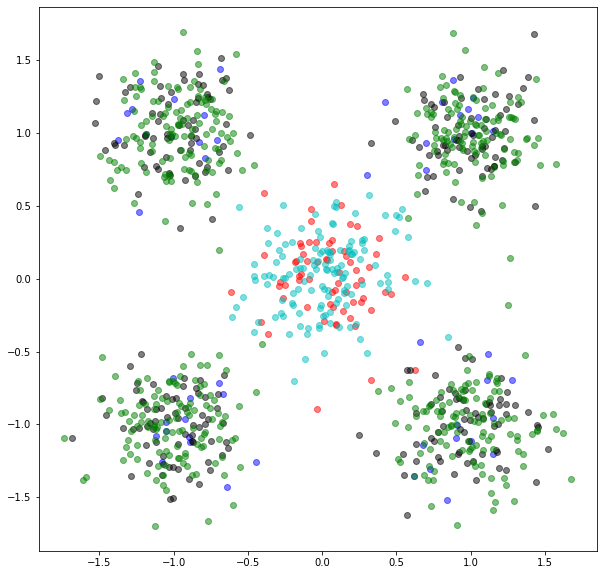

In [4]:
plt.figure(figsize=(10,10))
for x, y, y_hot in bd.val.seen:
    plt.plot(x[:,0], x[:,1], 'ob', alpha=0.5)

for x, y, y_hot in bd.val.unseen:
    plt.plot(x[:,0], x[:,1], 'or', alpha=0.5)

for x, y, y_hot in bd.test.seen:
    plt.plot(x[:,0], x[:,1], 'ok', alpha=0.5)

for x, y, y_hot in bd.test.unseen:
    plt.plot(x[:,0], x[:,1], 'oc', alpha=0.5)

for x, y, y_hot in bd.train:
    plt.plot(x[:,0], x[:,1], 'og', alpha=0.5)

## Initialize 1 Nearest Neighbors Classifier
Train 1 Nearest Neighbors Classifier (1NNC) for post processes of FeedForward output to compute the score.

In [5]:
knn = KNeighborsClassifier(1)
y_one_hot = LabelBinarizer().fit_transform(list(bd.data_dict.keys()))
knn.fit(
    [v['class_emb'] for v in bd.data_dict.values()],
    y_one_hot
)


KNeighborsClassifier(n_neighbors=1)

## Initialize & Train FF Neural Network

In [6]:
class FeedForward(tf.Module, am.base.BaseNeuralNetwork):
    def __init__(self, knn, dataset, optimizer=None):
        tf.Module.__init__(self, name='ff')

        status = [
            [0],
            [1],
            [2]
        ]

        self.knn = knn
        self.score_mtr = am.base.MetricBase(self,
                                    [tf.keras.metrics.CategoricalAccuracy()],
                                    status,
                                    [0]
                                    )

        self.cost_mtr = am.base.MetricBase(self,
                                    [tf.keras.metrics.MeanSquaredError()],
                                    status,
                                    [0],
                                    1
                                    )
        self.cost_loss = am.base.LossBase(self,
                                    [tf.keras.losses.MeanSquaredError()],
                                    status,
                                    [0]
                                    )
        am.base.BaseNeuralNetwork.__init__(self, status=status, dataset=dataset, optimizer=optimizer)
        self.fc1 = am.layers.FC(2, 128)
        self.fc2 = am.layers.FC(128, 256)
        self.fc3 = am.layers.FC(256, 512)
        self.fc4 = am.layers.FC(512, 1024)
        self.out = am.layers.FC(1024, 2)

    def __call__(self, inputs, is_score=False):
        x = self.fc1(inputs[0])
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        y = self.out(x)
        if is_score:
            y = self.knn.predict(y)
        return tuple([y])

In [7]:

opt = Adam(learning_rate=1e-2)
ff = FeedForward(knn=knn, dataset=bd, optimizer=opt)

In [8]:
ff.train(bd, 60, print_types=['train', 'val'])

2021-11-20 00:09:16.730164: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 1 finished
train cost: 11.116338729858398
train score: 0.5
val seen cost: 9.549651145935059
val seen score: 0.5
val unseen cost: 2.3852365016937256
val unseen score: 0.13636364042758942
val harmonic: 0.2142857313156128
Epoch 2 finished
train cost: 22.852447509765625
train score: 0.25
val seen cost: 21.61042594909668
val seen score: 0.25
val unseen cost: 14.788768768310547
val unseen score: 0.0
val harmonic: 0.0
Epoch 3 finished
train cost: 20.62516212463379
train score: 0.25
val seen cost: 19.704710006713867
val seen score: 0.26923078298568726
val unseen cost: 6.990176200866699
val unseen score: 0.0
val harmonic: 0.0
Epoch 4 finished
train cost: 11.123943328857422
train score: 0.3375000059604645
val seen cost: 10.094792366027832
val seen score: 0.2884615361690521
val unseen cost: 1.1104602813720703
val unseen score: 0.21212121844291687
val harmonic: 0.24447032809257507
Epoch 5 finished
train cost: 6.622351169586182
train score: 0.15000000596046448
val seen cost: 6.132576465606689

## Results Visualization
1. Plot cost/score curves for train and validation examples,
2. plot 1KNN space with validation and test outputs of FF.

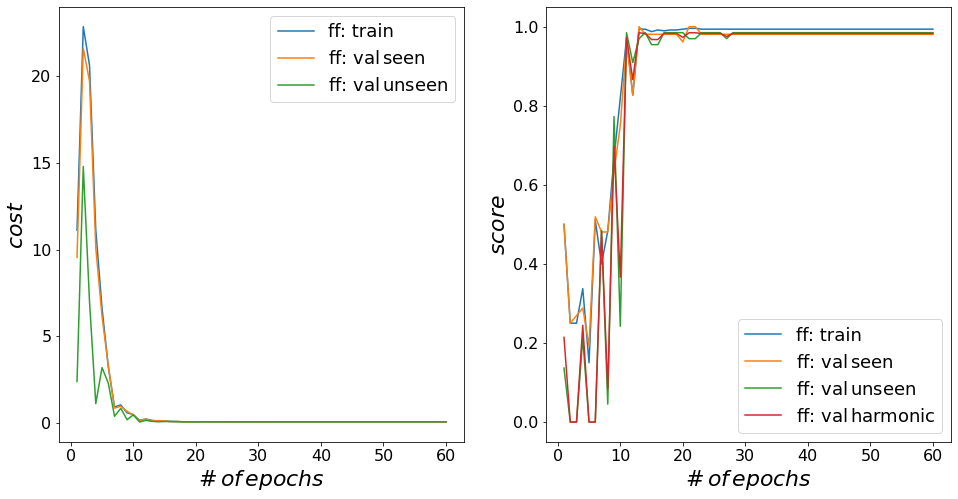

In [9]:
multiple_models_history_figure([ff])

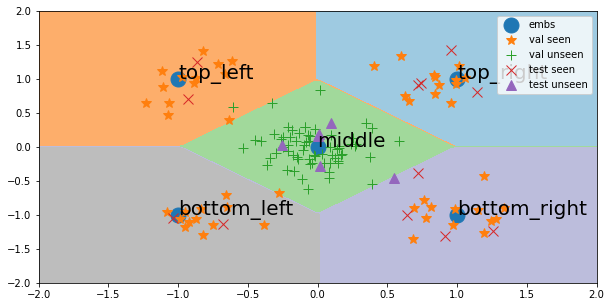

In [11]:
pca_dict, pca_emb, knn_pca = pca_denoising_preprocessing(ff, bd,
                                    [v['class_emb'] for v in bd.data_dict.values()], y_one_hot, pca_emb_idxs=[4, 3, 2, 1, 0],
                                     example_predicted_types=['val_seen', 'val_unseen', 'test_seen', 'test_unseen'])

pca_denoising_figure(pca_dict, pca_emb, knn_pca,
                     list(bd.data_dict.keys()), pca_emb_idxs=[4, 3, 2, 1, 0])
